In [1]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

In [2]:
# device 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.81MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()

        # 인코더 정의 입력을 400 차원으로
        self.fc1 = nn.Linear(28*28, 400)

        # 잠재 변수의 평균, log분산
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)

        # 디코더
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.3 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
### 손실 함수 정의 ###
# VAE 의 손실함수는 재구성 손실(BCE)과 KL발산(KLD)손실의 합으로 구성됩니다.
# beta 값은 KLㄴ 손실의 가중치르르 조절합니다.

beta = 1.0
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD

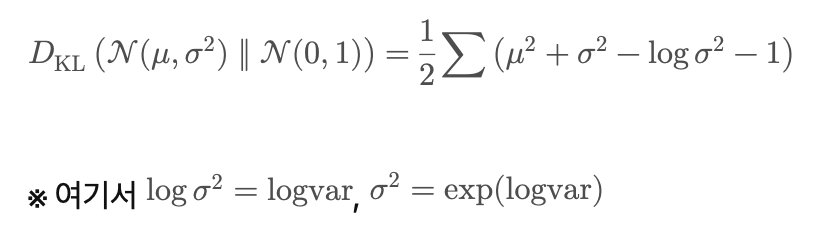

두 정규분포 $q(z) = {N}(\mu, \sigma^2)$와 $p(z) = {N}(0,1)$의 KL 발산을 계산해보면:

1. **정의부터 시작합니다.**  
   일반적인 KL 발산의 정의는  
   $
   D_{\text{KL}}(q(z) \parallel p(z)) = \int q(z) \log \frac{q(z)}{p(z)} \, dz
   $  
   입니다.

2. **각 분포의 확률 밀도 함수를 대입합니다.**  
   - q(z)의 밀도:  
     $
     q(z) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(z-\mu)^2}{2\sigma^2}\right)
     $
   - p(z)의 밀도:  
     $
     p(z) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{z^2}{2}\right)
     $

3. **로그의 차이를 계산합니다.**  
   $
   \log \frac{q(z)}{p(z)} = \log\left(\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(z-\mu)^2}{2\sigma^2}\right) \Big/ \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{z^2}{2}\right)\right)
   $\
   여기서 로그를 분리하면,  
   $log \frac{q(z)}{p(z)} = -\frac{1}{2}\log(\sigma^2) -\frac{(z-\mu)^2}{2\sigma^2} + \frac{z^2}{2}
   $

4. **q(z)에 대해 기댓값을 취하는 적분을 수행하면,**  
   여러 표준적 통계량(예, $\mathbb{E}_{q}[z] = \mu, \mathbb{E}_{q}[z^2] = \mu^2+\sigma^2$)을 사용하여, 적분 결과가  
   $
   D_{\text{KL}}(q(z) \parallel p(z)) = \frac{1}{2}\left(\mu^2 + \sigma^2 - 1 - \log \sigma^2\right)
   $
   로 나오게 됩니다.

5. **다변량일 경우**  
   각 차원마다 위와 같은 계산을 진행하면, 최종 식은  
   $
   D_{\text{KL}}(q(z|x) \parallel p(z)) = \frac{1}{2} \sum_{i=1}^{d} \left( \mu_i^2 + \sigma_i^2 - 1 - \log \sigma_i^2 \right)
   $
   가 됩니다.


In [6]:
### 모델 학습 : 2D 잠재 공간으로 학습 ###
# 잠재 공간 차원 설정 (여기서는 2차원)

latent_dim = 2
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

print("2D 잠재 공간으로 학습 시작..")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.
    for data, _ in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset)}')

2D 잠재 공간으로 학습 시작..
Epoch 1, Loss: 205.27219182942707
Epoch 2, Loss: 175.88828190104167
Epoch 3, Loss: 170.2756069498698
Epoch 4, Loss: 167.36880208333332
Epoch 5, Loss: 165.65714490559895
Epoch 6, Loss: 164.34326910807292
Epoch 7, Loss: 163.1808740234375
Epoch 8, Loss: 162.1736938313802
Epoch 9, Loss: 161.31624908854167
Epoch 10, Loss: 160.57204921875
Epoch 11, Loss: 159.86849763997395
Epoch 12, Loss: 159.21538100585937
Epoch 13, Loss: 158.69753608398437
Epoch 14, Loss: 158.16870797526042
Epoch 15, Loss: 157.7246897949219
Epoch 16, Loss: 157.29947158203126
Epoch 17, Loss: 156.87532849934897
Epoch 18, Loss: 156.52424607747395
Epoch 19, Loss: 156.2260971842448
Epoch 20, Loss: 155.90385838216145
Epoch 21, Loss: 155.66154262695312
Epoch 22, Loss: 155.35384742838542
Epoch 23, Loss: 155.13587154947916
Epoch 24, Loss: 154.78932998046875
Epoch 25, Loss: 154.67795224609375
Epoch 26, Loss: 154.34569925130208
Epoch 27, Loss: 154.16027467447915
Epoch 28, Loss: 153.9191140299479
Epoch 29, Loss: 153

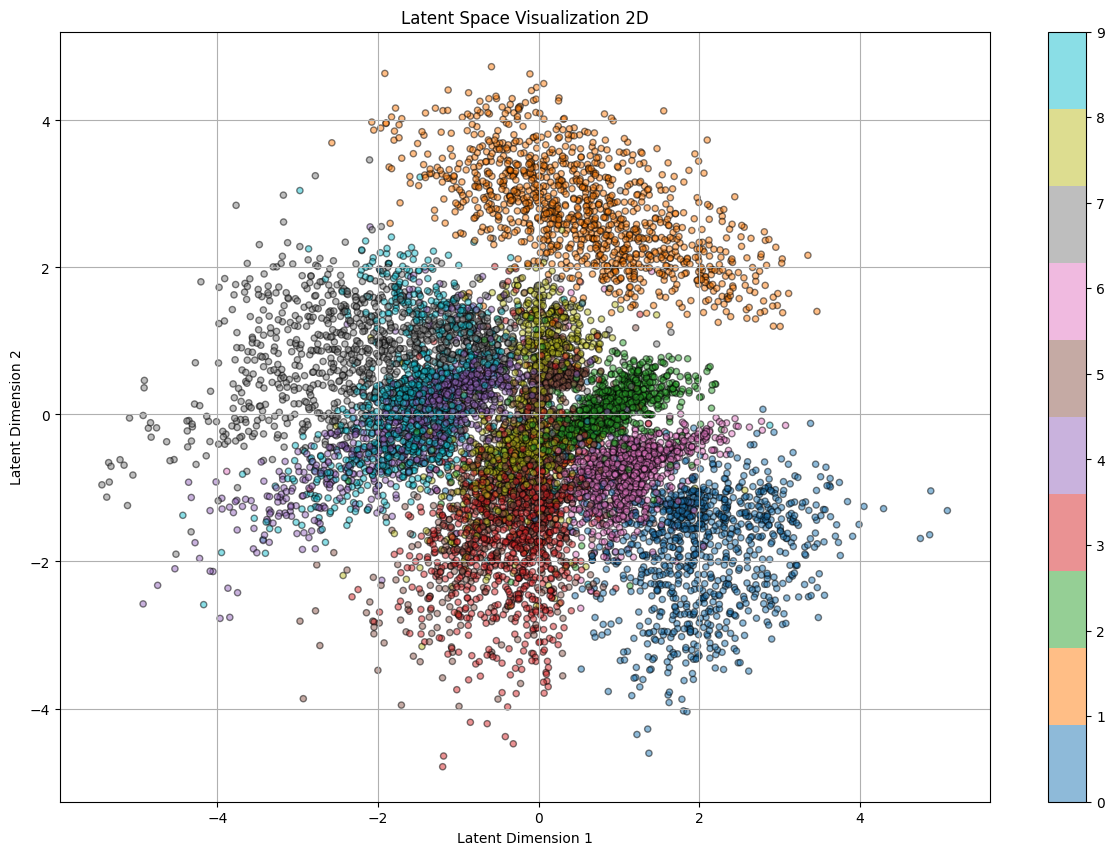

In [7]:
### 잠재 공간 시각화 (2D) 및 테스트 데이터셋 처리 ###

model.eval()
all_z = []
all_labels = []

# 테스트 데이터셋 다운로드 및 로드
with torch.no_grad():
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)

    # 테스트 데이터셋에 대해 인코딩 및 잠재 변수 샘플링 진행
    for data, labels in testloader:
        data = data.to(device)
        mu, logvar = model.encode(data.view(-1, 28*28))
        z = model.reparameterize(mu, logvar)
        z = z.cpu().numpy()

        all_z.append(z)
        all_labels.append(labels)

    all_z = np.concatenate(all_z)
    all_labels = np.concatenate(all_labels)

    # 2D 잠재 공간에 대해 산점도
    plt.figure(figsize=(15,10))
    scatter = plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', alpha=0.5, edgecolors='k', s=20)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization 2D')
    plt.grid(True)
    plt.show()

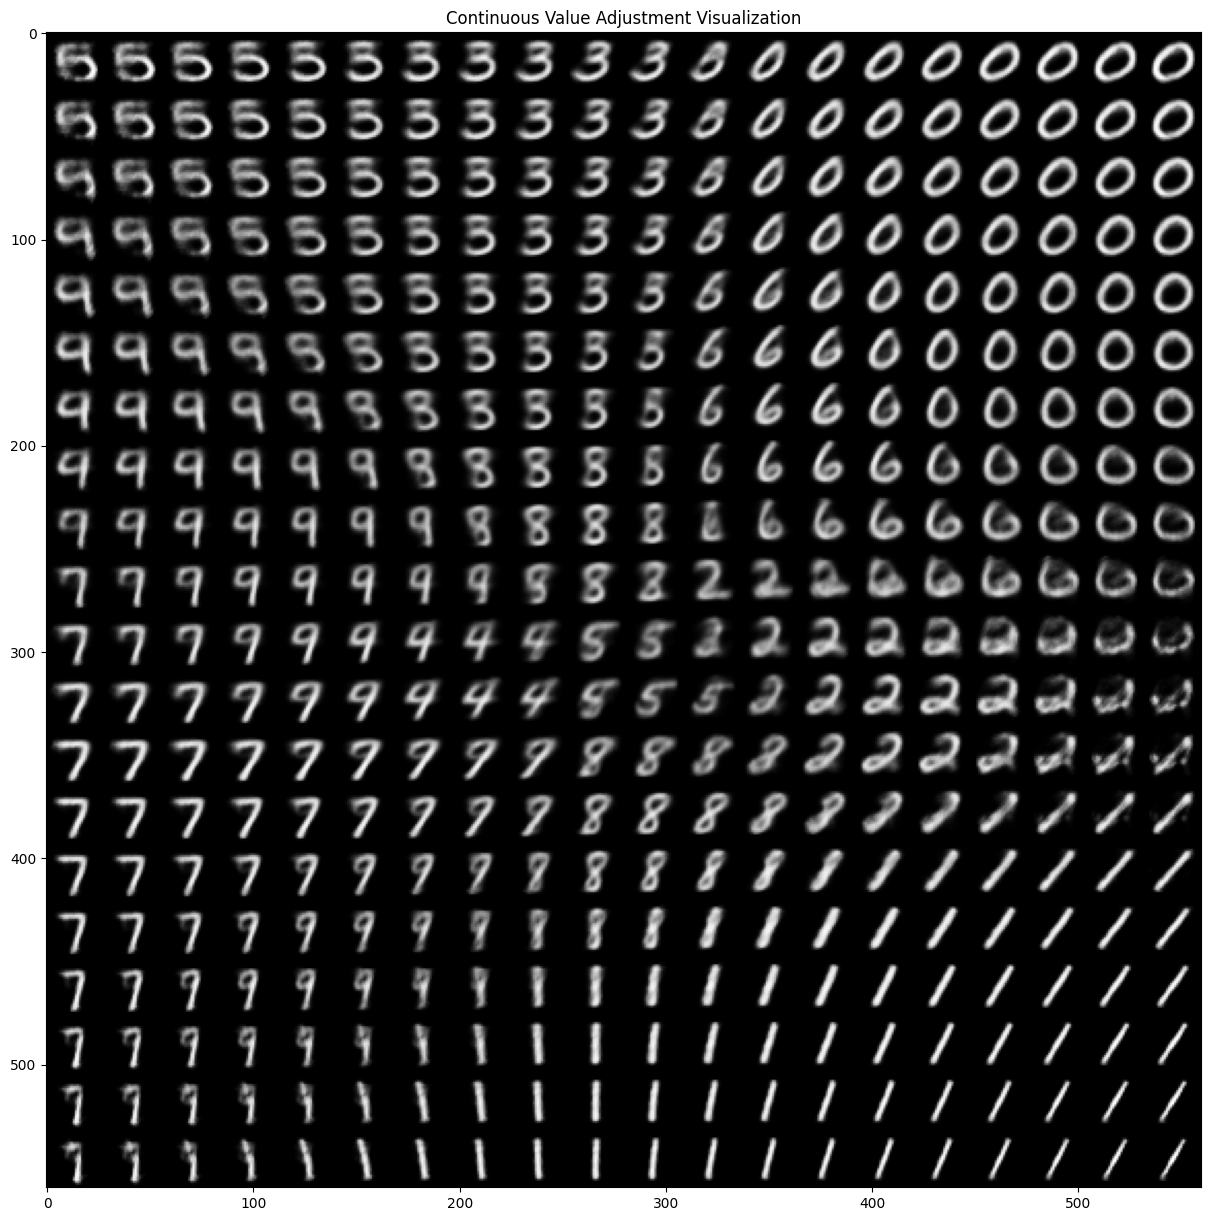

In [11]:
### 잠재 공간을 활용한 새로운 데이터 생성 (연속적 값 조정) ###
# 잠재 공간에서 샘플을 생성하여 디코더로 복원한 후, 그 결과를 그리드 형태로 시각화 합니다.

with torch.no_grad():
    grid_x = np.linspace(-3, 3, 20)     # x축 범위 및 샘플링 개수 설정
    grid_y = np.linspace(-3, 3, 20)     # y축 범위 및 샘플링 개수 설정
    figure = np.zeros((28*20, 28*20))   # 전체 이미지를 저장할 빈 배열 생성
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            # 현재 좌료(xi, yi)를 잠재 변수로 변환 후 디코딩
            z_sample = torch.Tensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j *28: (j + 1) * 28] = digit

    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap='gray')
    plt.title('Continuous Value Adjustment Visualization')
    plt.show()

In [12]:
### 잠재 공간 차원 확장: 128D로 재학습 ###
# 잠재 공간의 차원을 128로 확장하여 학습하면 재구성 품질이 개선될 수 있습니다.
laten_dim = 128
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50

print("128D 잠재 공간으로 학습 시작...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch +1}, Loss: {train_loss / len(trainloader.dataset)}')

128D 잠재 공간으로 학습 시작...
Epoch 1, Loss: 205.0866490234375
Epoch 2, Loss: 172.41425930989584
Epoch 3, Loss: 167.72969521484376
Epoch 4, Loss: 165.25654418945314
Epoch 5, Loss: 163.4687153971354
Epoch 6, Loss: 162.11921949869793
Epoch 7, Loss: 161.07892083333334
Epoch 8, Loss: 160.07096396484374
Epoch 9, Loss: 159.30717067057293
Epoch 10, Loss: 158.53177194010416
Epoch 11, Loss: 157.84449116210936
Epoch 12, Loss: 157.35267197265625
Epoch 13, Loss: 156.78538020833332
Epoch 14, Loss: 156.3355861328125
Epoch 15, Loss: 155.94395699869793
Epoch 16, Loss: 155.55431604817707
Epoch 17, Loss: 155.2132852376302
Epoch 18, Loss: 154.85697747395832
Epoch 19, Loss: 154.54464567057292
Epoch 20, Loss: 154.33948893229166
Epoch 21, Loss: 154.03933489583332
Epoch 22, Loss: 153.7848301106771
Epoch 23, Loss: 153.5436016764323
Epoch 24, Loss: 153.29632449544272
Epoch 25, Loss: 153.10247670898437
Epoch 26, Loss: 153.0032631673177
Epoch 27, Loss: 152.74326298828126
Epoch 28, Loss: 152.53229833984375
Epoch 29, Loss

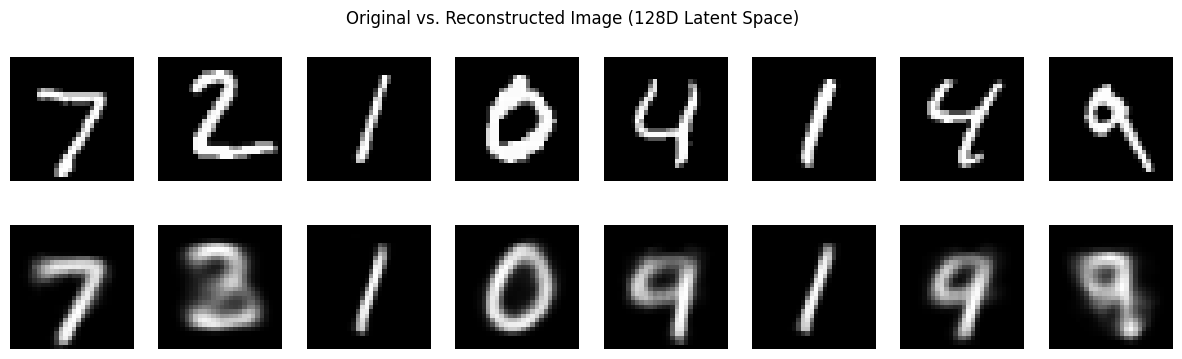

In [27]:
### 128D 잠재 공간 재구성 결과 시각화 ###
model.eval()
with torch.no_grad():
    # 데스크 데이터셋에서 일부 데이커를 선택하여 재구성 결과 확인
    data, _ = next(iter(testloader))
    data = data.to(device)
    recon, _, _ = model(data)
    recon = recon.view(-1, 1, 28, 28).cpu().numpy()

    # 원본 이미지와 재구성 이미지를 나란히 비교하여 시각화
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        # 첫 번째 행: 원본 이미지
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # 두 번째 행: 재구성된 이미지
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle('Original vs. Reconstructed Image (128D Latent Space)')
    plt.show()